In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy 

from astropy.io import fits
from astroquery.mast import Observations

In [ ]:
from astroquery.mast import Observations
all_obs = Observations.query_criteria(provenance_name="glass-jwst")
data_products = Observations.get_product_list(all_obs)
Observations.download_products(data_products)

Now that we have the fits files for Abell2744, we can make an rgb image using the f356 (r), f200(g), f90(b) images for rgb in SAO DS9, from there we can export an rgb png image

In [ ]:
!pip install photutils 

the above step install photutils in the jupter notebook environment 

In [ ]:
import photutils
from photutils.detection import DAOStarFinder
from photutils.aperture import aperture_photometry, CircularAperture

from astropy.io import fits
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma

from photutils.segmentation import detect_sources, SourceCatalog, deblend_sources, detect_threshold
from photutils.background import Background2D, MedianBackground
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u

from astropy.visualization import make_lupton_rgb
from astropy.visualization import SqrtStretch, simple_norm, ImageNormalize 
from skimage.io import imread

In [3]:
# Load the FITS file
#fits_path = 'path_to_file.fits'
#with fits.open(fits_path) as hdul:
    #image_data = hdul[0].data

In [4]:
from PIL import Image

# Increase the maximum number of pixels allowed
Image.MAX_IMAGE_PIXELS = None  # Disables limit

In [5]:
# Load the PNG file
png_path = '.\Abell2744_6663px.png'
image_data = imread(png_path)

In [6]:
# Since the PNG is RGB, we need to convert it to grayscale
# We use a simple average of the R, G, B channels for this example
image_data_gray = np.mean(image_data, axis=2)

In [7]:
# Subtract the background
sigma = 3.0 * gaussian_fwhm_to_sigma  # for example, FWHM = 3 pixels
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
bkg_estimator = MedianBackground()
bkg = Background2D(image_data_gray, (50, 50), filter_size=(3, 3),
                   bkg_estimator=bkg_estimator)
data_subtracted = image_data_gray - bkg.background

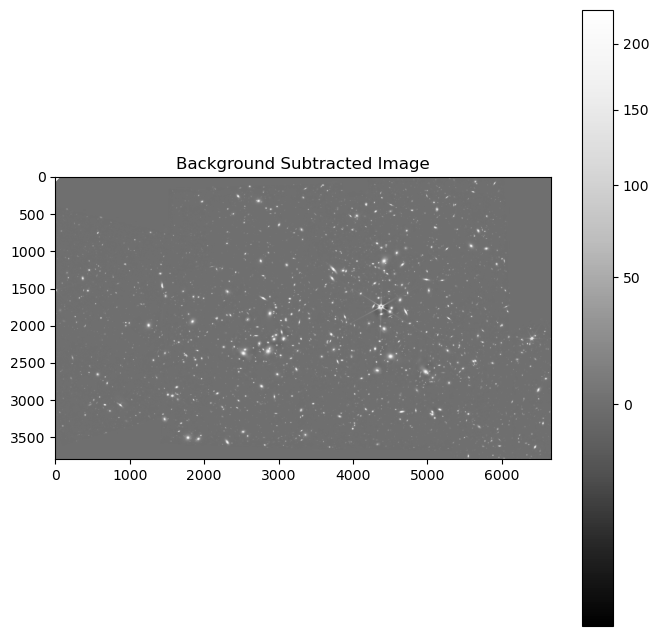

In [8]:
# Normalize the image
norm = ImageNormalize(stretch=SqrtStretch())
plt.figure(figsize=(8, 8))
plt.imshow(data_subtracted, cmap='Greys_r', norm=norm)
plt.title('Background Subtracted Image')
plt.colorbar()
plt.show()

In [19]:
# Detect sources

# Increase the nsigma to reduce sensitivity
threshold = detect_threshold(data_subtracted, nsigma=3)  

# Increase number of pixels to avoid detecting very small groups of pixels as sources
segm = detect_sources(data_subtracted, threshold, npixels=10)  # more pixels required to be considered a source

# Adjust the contrast parameter to deblend sources
segm_deblend = deblend_sources(data_subtracted, segm, npixels=3, nlevels=32, contrast=0.05)

Deblending:   0%|          | 0/11029 [00:00<?, ?it/s]

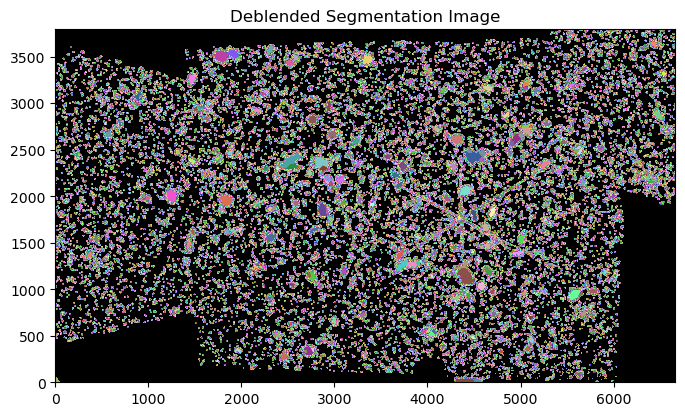

In [20]:
# Plot segmentation
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
cmap = segm_deblend.make_cmap()
ax.imshow(segm_deblend, origin='lower', cmap=cmap)
plt.title('Deblended Segmentation Image')
plt.show()

In [21]:
# Measure properties of detected sources
catalog = SourceCatalog(data_subtracted, segm_deblend)

In [22]:
# Print the table of properties
tbl = catalog.to_table(columns=['xcentroid', 'ycentroid', 'ellipticity'])
print(tbl)

    xcentroid          ycentroid          ellipticity    
                                                         
------------------ ------------------ -------------------
25.795692150613007 27.428373910845888  0.4246391371792463
 5741.185871885799 1.1235682605572113  0.9142512947331053
 5786.130325662034 0.9786855666355079  0.8479686836781772
 6004.485652508606 0.9422208343687126  0.2889822677437468
5827.7837031041945 11.603652332602035  0.4592719175044234
5908.9680267719605 14.303011947422675  0.6627526486955235
 5983.072927881703 16.795475429958778 0.46511588127026804
 5402.356273339983   16.8789381501352  0.5590902260759462
 5289.968101743418 27.148408569178898  0.3599166579634694
 5338.491557432118  21.10782125264653  0.3814059532722225
               ...                ...                 ...
 6198.895212515666  3768.466411144976  0.6336984653655255
 6189.741762928326  3774.484083462997 0.35574773060217957
 5717.223168668971  3776.338898579161 0.30768569045822824
 5722.22861878

In [17]:
from astropy.constants import G, c
from astropy.cosmology import FlatLambdaCDM

#speed of light
c = c.value  
# Gravitational constant 
G = G.value  
# Hubble constant 
H0 = 73 
# Omega matter
Om0 = 0.27  
# Redshift of the Abdell 2744 galaxy cluster
z_lens = 0.30800 

# Define the cosmology
cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

# Example lens mass in kg
M_lens = 4e12 * 1.989e30  
#M_lens = 7.956e42 
# Angular diameter distance to the lens in meters
D_l = cosmo.angular_diameter_distance(z_lens).value  
# Angular diameter distance to the source in meters (assuming source is at twice the lens redshift)
D_s = cosmo.angular_diameter_distance(2 * z_lens).value  
# Angular diameter distance between the lens and the source in meters
D_ls = D_s - D_l  

# Initialize total mass
total_mass_Einstein = 0

In [ ]:
# Iterate over the catalog of sources
for obj in catalog:
    ellipticity = obj.ellipticity
    if ellipticity > 0.2:  # Threshold for ellipticity
        # Calculate the Einstein radius in radians
        theta_E = np.sqrt(4 * G * M_lens / c**2 * (D_ls / (D_l * D_s)))
        # Critical density in kg/m^2
        sigma_crit = (cosmo.critical_density(z_lens) * (3.086e+22)**2).value  
        # Mass within the Einstein radius in kg
        mass_Einstein = np.pi * (theta_E**2 * D_l**2 * sigma_crit)
         # Add the mass to the total
        total_mass_Einstein += mass_Einstein

        # Display the results
        #print(f"Object ID: {obj.id}")
        print(f"Ellipticity: {ellipticity}")
        print(f"Einstein Radius (radians): {theta_E}")
        print(f"Approx. Lensing Mass (kg): {mass_Einstein}\n")
        # Display the final total mass
        print(f"Total Approx. Einstein Mass (kg): {total_mass_Einstein}")

Calculated Total Approx. Einstein Mass (kg): 6.289501477316923e+41

Abell2744 is known to be roughly 4 trillion suns, or about 7.956e42 Kg 

According to a study from 2012, its mass is 22.20+22.20+/- 1.25· 10^14 Solar Masses 

Below we try this using a differnt mass distribution model, instead of the flat lambda CDM, we Navarro–Frenk–White profile for the dark matter distribution 

In [ ]:
# NFW profile parameters for the cluster

# Characteristic density in kg/m^3
rho_0 =  1.05e-23
# Scale radius in meters
r_s =  4.26e22

#compute mass within a given radius for the NFW profile
def nfw_mass(r, rho_0, r_s):
    x = r / r_s
    mass = 4 * np.pi * rho_0 * r_s**3 * (np.log((r_s + r) / r_s) - r / (r_s + r))
    return mass

# Iterate over the source catalog to compute the lensing mass
total_mass = 0
for obj in catalog:
    ellipticity = obj.ellipticity
    if ellipticity > 0.2:
        # Use the NFW profile to estimate mass inside the Einstein radius
        theta_E = np.sqrt(4 * G * M_lens / c**2 * (D_ls / (D_l * D_s)))  # Einstein radius
        r_Einstein = theta_E * D_l  # Physical radius corresponding to Einstein radius
        mass_Einstein = nfw_mass(r_Einstein, rho_0, r_s)  # Mass within Einstein radius using NFW profile
    
        total_mass += mass_Einstein
        
        print(f"Ellipticity: {ellipticity}, Lensing Mass: {mass_Einstein} kg")

print(f"Total Dark Matter Mass Inferred: {total_mass} kg")

3 hour run:

Total Dark Matter Mass Inferred: 1.3623184657561997e+35 kg

Number of objects found: 138821

Schwinn, J., Jauzac, M., Baugh, C. M., Bartelmann, M., Eckert, D., Harvey, D., Natarajan, P., & Massey, R. (2017). Abell 2744: too much substructure for ΛCDM? Monthly Notices of the Royal Astronomical Society, 467(3), 2913–2923. https://doi-org.ezproxy.cul.columbia.edu/10.1093/mnras/stx277